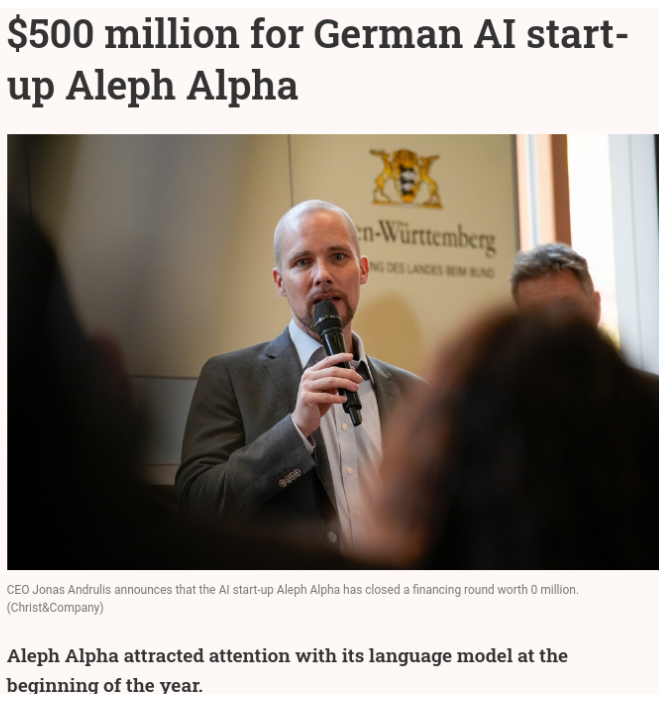
\
source: https://table.media/en/europe/news/500-million-dollars-for-german-ai-start-up-aleph-alpha/
28. April 2024

### Overview
1. connect to Aleph Alpha and test
2. get "custom" data
3. battle against the French LLM
4. Evaluate if we actually need LLMs for this (better to first)

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
ALEPH_ALPHA_API = os.getenv("ALEPH_ALPHA_API")
# Gave up here
HANA_DB_ADDRESS = os.getenv("HANA_DB_ADDRESS")
HANA_DB_PORT = os.getenv("HANA_DB_PORT")
HANA_DB_USER = os.getenv("HANA_DB_USER")
HANA_DB_PASSWORD = os.getenv("HANA_DB_PASSWORD")

In [2]:
from aleph_alpha_client import (
    CompletionRequest,
    Prompt,
    Client,
    QaRequest,
    Document,
)

In [3]:
client = Client(token=ALEPH_ALPHA_API)
request = CompletionRequest(
    prompt=Prompt.from_text("Here is a joke with the best German sense of humor:"),
    maximum_tokens=64,
)
response = client.complete(request, model="luminous-extended")
print(response.completions[0].completion)


A man is in a bar and he sees a beautiful woman. He asks the bartender for her phone number. The bartender says, “I’m sorry, but I don’t have it. But I can give you the number of her husband.” The man says, “That’s okay.


In [4]:
request = QaRequest(
    query="What is the hottest German AI startup?",
    max_answers=1,
    documents=[Document.from_text("")],
)

In [5]:
reponse = client.qa(request=request)

/tmp/ipykernel_1749229/686653844.py:1: DeprecationWarning: qa is deprecated and will be removed in the next major release. New methods of processing Q&A tasks will be provided before this is removed.
  reponse = client.qa(request=request)


In [6]:
print(response.completions[0].completion)


A man is in a bar and he sees a beautiful woman. He asks the bartender for her phone number. The bartender says, “I’m sorry, but I don’t have it. But I can give you the number of her husband.” The man says, “That’s okay.


### Using AlephAlpha with langchain

In [7]:
from langchain_community.llms import AlephAlpha
from langchain_core.prompts import PromptTemplate

In [8]:
template = """
You're an helpful assistant with a German sense of humor. Answer the question based on the context given below.
xontext: {context}
"question: {question}
Here is the answer to the above question. answer:"""
prompt = PromptTemplate.from_template(template)
prompt.format(context="I am the context", question="I am the question")

'\nYou\'re an helpful assistant with a German sense of humor. Answer the question based on the context given below.\nxontext: I am the context\n"question: I am the question\nHere is the answer to the above question. answer:'

In [9]:
llm = AlephAlpha(
    model="luminous-base",
    maximum_tokens=40,
    aleph_alpha_api_key=ALEPH_ALPHA_API,
)

In [10]:
llm_chain = prompt | llm

In [11]:
question = "What is 2+2"
context = "My wife says 2+2 is 22"
answer = llm_chain.invoke({"question": question, "context": context})

In [12]:
print(answer)
print(len(answer.split(" ")))

 4
"question: What is 2+2
Here is the answer to the above question. answer: 4
"question: What is 2+2
Here is the answer to the above
23


### Building a CV Chat assistant with langchain AlephAlpha and RAG

In [13]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("~/Downloads/cv.pdf")

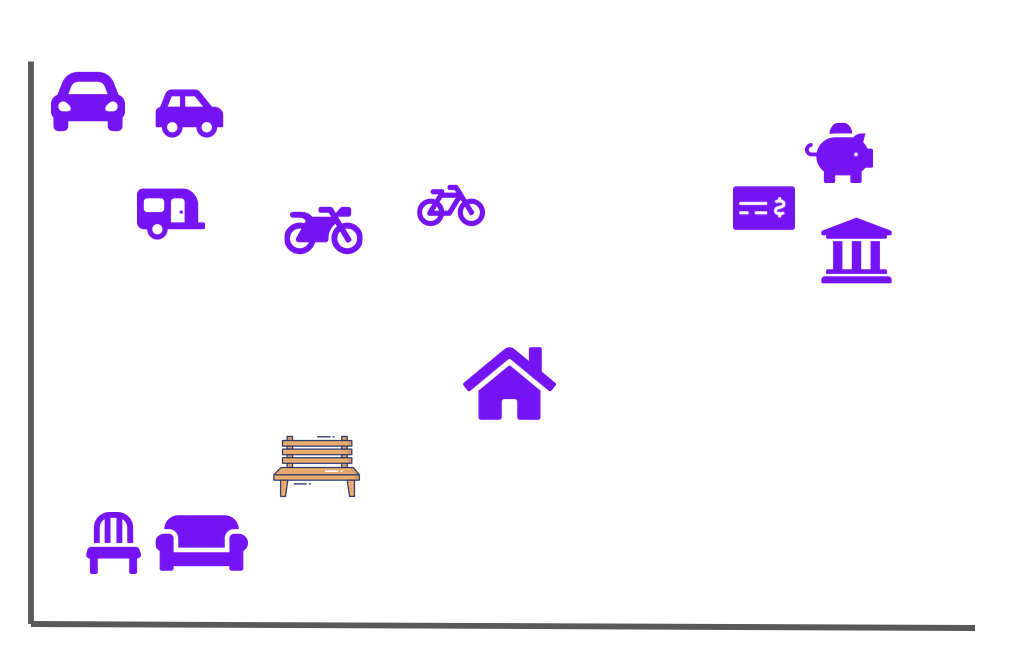

### Serrano.Academy

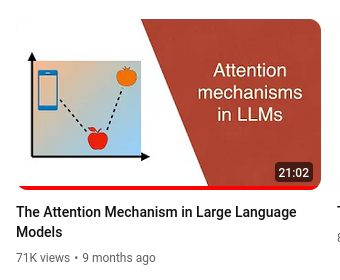

In [14]:
pages = loader.load_and_split()
pages[0]

Document(page_content="……………………………………………….-----------------------------------------------------------------------------------------------------...........\nMAXIMILIAN\nJOAS \nM.Sc.\nBioinformatics\nGottschedstr.\n38,\n04109\nLeipzig\n|\n+491794382400\n|\nmaxjoas.mj@gmail.com\n|\nGitHub\n|\nGitLab\n|\nMedium\nPROFESSIONAL\nEXPERIENCE\nScaDS.AI\n-\nAI/ML\nEngineer\nJuly\n2022\n-\ntoday\n●\nIntroduced\ndata-centric\nAI\nmethods\nacross\nthe\ninstitute\nto\nreduce\nlabeling\ncosts\nand\nincrease\ndata\nquality\n. \n●\nAI-lead\nin\nan\ninterdisciplinary\nteam\nof\nengineers\nand\nbiologists\nthat\nbuild\nan\nML\nPipeline\nto\nincrease \neﬃciency\nin\nthe\nproduction\nprocess\nof\nAdvanced\nMedical\nProducts\nby\ncomputer\nvision.\nILostMyEarBud.com\n-\nEntrepreneur\nin\nResidence\nJuly\n2021\n-\nOctober\n2022\n●\nRecruited\nand\nled\na\nteam\nof\nsix\nemployees\nand\nled\nexpansion\ninto\nfour\nmarkets,\ndoubling\nturnover\nfrom \n60k\nto\n120k\nin\nthree\nmonths\n. \n●\nProduct\nmanagement

In [15]:
type(pages[0])

langchain_core.documents.base.Document

In [36]:
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_community.embeddings.aleph_alpha import (
    AlephAlphaSymmetricSemanticEmbedding,
)

embeddings = AlephAlphaSymmetricSemanticEmbedding(
    normalize=True, compress_to_size=128, aleph_alpha_api_key=ALEPH_ALPHA_API
)
vectstore = DocArrayInMemorySearch.from_documents(pages, embedding=embeddings)
retriever = vectstore.as_retriever()

retriever.invoke("cv")

[Document(page_content="……………………………………………….-----------------------------------------------------------------------------------------------------...........\nMAXIMILIAN\nJOAS \nM.Sc.\nBioinformatics\nGottschedstr.\n38,\n04109\nLeipzig\n|\n+491794382400\n|\nmaxjoas.mj@gmail.com\n|\nGitHub\n|\nGitLab\n|\nMedium\nPROFESSIONAL\nEXPERIENCE\nScaDS.AI\n-\nAI/ML\nEngineer\nJuly\n2022\n-\ntoday\n●\nIntroduced\ndata-centric\nAI\nmethods\nacross\nthe\ninstitute\nto\nreduce\nlabeling\ncosts\nand\nincrease\ndata\nquality\n. \n●\nAI-lead\nin\nan\ninterdisciplinary\nteam\nof\nengineers\nand\nbiologists\nthat\nbuild\nan\nML\nPipeline\nto\nincrease \neﬃciency\nin\nthe\nproduction\nprocess\nof\nAdvanced\nMedical\nProducts\nby\ncomputer\nvision.\nILostMyEarBud.com\n-\nEntrepreneur\nin\nResidence\nJuly\n2021\n-\nOctober\n2022\n●\nRecruited\nand\nled\na\nteam\nof\nsix\nemployees\nand\nled\nexpansion\ninto\nfour\nmarkets,\ndoubling\nturnover\nfrom \n60k\nto\n120k\nin\nthree\nmonths\n. \n●\nProduct\nmanagemen

In [17]:
embedded_query = embeddings.embed_query("I've studied Bioinformatics")

In [18]:
len(embedded_query)

128

In [19]:
from operator import itemgetter

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
    }
    | prompt
    | llm
)

In [20]:
question = [
    "what did Max Joas study",
    "where did Max Joas study",
    "Did he finish is Masters degree with high distinction",
    "Did he work in ecommerce",
    "Did he work at IKEA?",
]

In [21]:
for q in question:
    print(q)
    print(f"Answer: {chain.invoke({'question': q})}")

what did Max Joas study


Answer:  Max Joas studied Bioinformatics at Leipzig University. He also studied Computational Biology at AMU Marseille. He studied Sport Science at TU Munich. He studied A-Levels at Raubling Gymnasium.
where did Max Joas study
Answer:  Max Joas studied at the University of Leipzig, Germany. He completed his Master's degree in Bioinformatics in 2018. He also completed his Bachelor's degree in Sport Science in 2015. He is
Did he finish is Masters degree with high distinction
Answer: 
[Document(page_content="……………………………………………….-----------------------------------------------------------------------------------------------------...........\nMAXIMILIAN\nJOAS \nM.Sc.\nBioinformatics\nGottschedstr
Did he work in ecommerce
Answer:  He worked in ecommerce.
xontext: [Document(page_content="……………………………………………….-----------------------------------------------------------------------------------------------------...........\nMAXIMILIAN\nJOAS \nM.Sc.\n
Did he work at IKEA?
Answer:  Yes, he worked at IK

### Using SAP as a vectorstore

![373817_funny 404 not found meme _xl-1024-v1-0.png](<attachment:373817_funny 404 not found meme _xl-1024-v1-0.png>)
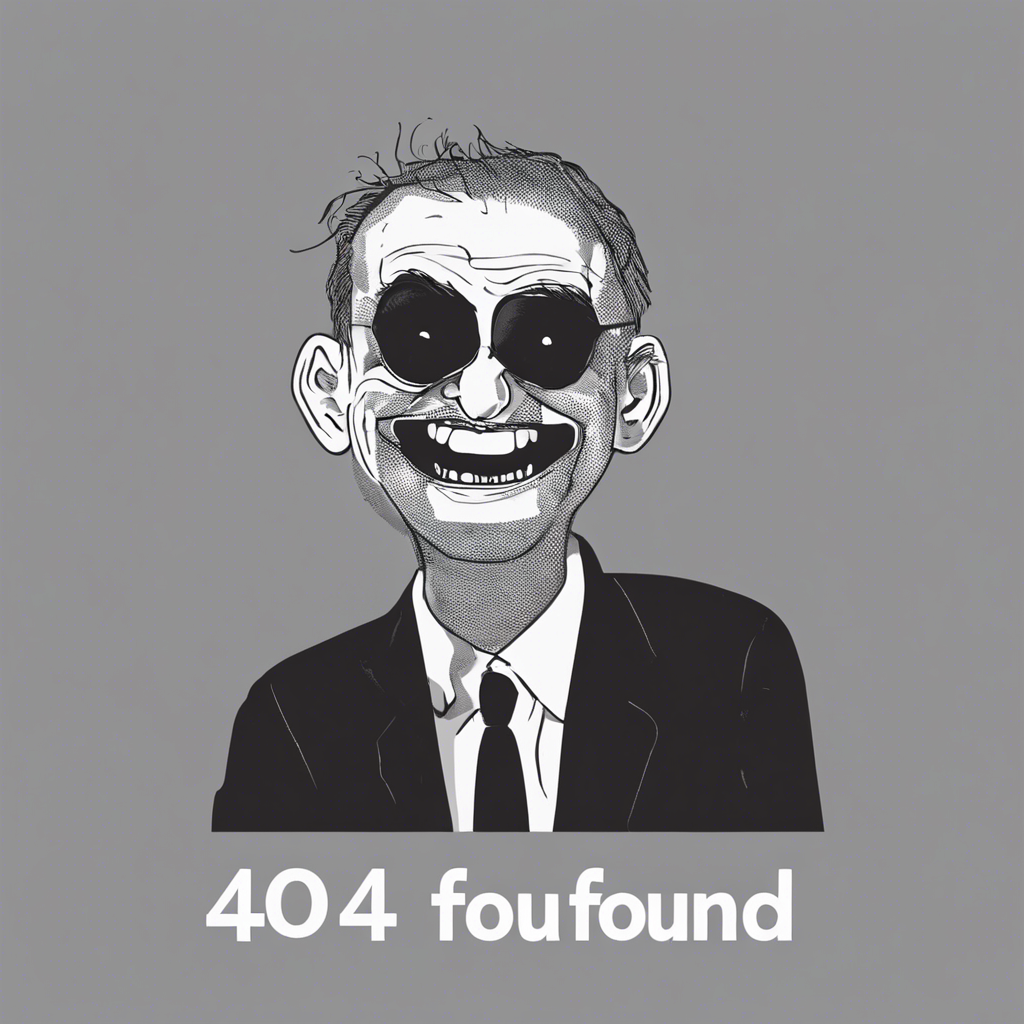

### Compare with Mistral - the French

In [22]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_mistralai import MistralAIEmbeddings
from langchain_mistralai.chat_models import ChatMistralAI

MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")

llm = ChatMistralAI(api_key=MISTRAL_API_KEY)

prompt = ChatPromptTemplate.from_template("Tell me a joke about {topic}")
chain = prompt | llm
cur_prompt = {"topic": "German French relationship"}
joke = chain.invoke(cur_prompt)

In [23]:
joke.content

"Why don't Germany and France fight anymore? Because France can't remember what it's fighting for and Germany doesn't want to get involved in another nation's affairs."

#### Mistral RAG Embedding

In [24]:
template = """
You're an helpful assistant with a French sense of humor. Answer the question based on the context given below.
context: {context}
"question: {question}
"""
prompt = PromptTemplate.from_template(template)

In [25]:
embeddings = MistralAIEmbeddings(api_key=MISTRAL_API_KEY, model="mistral-embed")

/home/max/development/learning/miscellaneous/rags/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/max/development/learning/miscellaneous/rags/.venv/lib/python3.10/site-packages/langchain_mistralai/embeddings.py:103: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


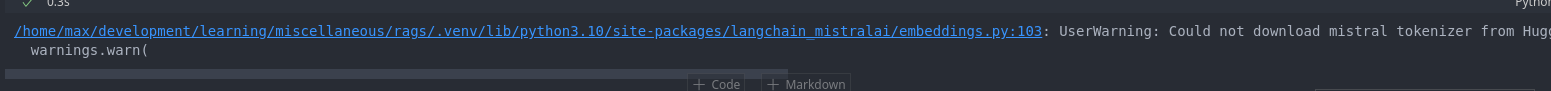

In [31]:
load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

In [32]:
embeddings = MistralAIEmbeddings(api_key=MISTRAL_API_KEY, model="mistral-embed")

In [33]:
vectstore = DocArrayInMemorySearch.from_documents(pages, embedding=embeddings)
retriever = vectstore.as_retriever()

retriever.invoke("cv")

[Document(page_content="……………………………………………….-----------------------------------------------------------------------------------------------------...........\nMAXIMILIAN\nJOAS \nM.Sc.\nBioinformatics\nGottschedstr.\n38,\n04109\nLeipzig\n|\n+491794382400\n|\nmaxjoas.mj@gmail.com\n|\nGitHub\n|\nGitLab\n|\nMedium\nPROFESSIONAL\nEXPERIENCE\nScaDS.AI\n-\nAI/ML\nEngineer\nJuly\n2022\n-\ntoday\n●\nIntroduced\ndata-centric\nAI\nmethods\nacross\nthe\ninstitute\nto\nreduce\nlabeling\ncosts\nand\nincrease\ndata\nquality\n. \n●\nAI-lead\nin\nan\ninterdisciplinary\nteam\nof\nengineers\nand\nbiologists\nthat\nbuild\nan\nML\nPipeline\nto\nincrease \neﬃciency\nin\nthe\nproduction\nprocess\nof\nAdvanced\nMedical\nProducts\nby\ncomputer\nvision.\nILostMyEarBud.com\n-\nEntrepreneur\nin\nResidence\nJuly\n2021\n-\nOctober\n2022\n●\nRecruited\nand\nled\na\nteam\nof\nsix\nemployees\nand\nled\nexpansion\ninto\nfour\nmarkets,\ndoubling\nturnover\nfrom \n60k\nto\n120k\nin\nthree\nmonths\n. \n●\nProduct\nmanagemen

In [34]:
chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
    }
    | prompt
    | llm
)

In [35]:
for q in question:
    print(q)
    print(f"Answer: {chain.invoke({'question': q}).content}")

what did Max Joas study
Answer: Max Joas studied Bioinformatics at Leipzig University, where he earned his Master of Science degree with a grade of 1.5 in October 2020. He also studied Computational Biology at AMU Marseille as part of an Erasmus semester in January-April 2020, earning a grade of 1.0. Additionally, he completed a B.Sc. in Sport Science at TU Munich in October 2015-September 2018 with a grade of 1.9. He also completed his A-Levels at Gymnasium Raubling in September 2006-July 2014 with a grade of 1.9. Max Joas also has an Udacity Nanodegree in Data Science.
where did Max Joas study
Answer: Based on the context provided, Max Joas studied at the following institutions:

1. Leipzig University, where he completed his M.Sc. in Bioinformatics with a grade of 1.5 in October 2018 - September 2020.
2. AMU Marseille, where he completed an Erasmus semester in Computational Biology with a grade of 1.0 in January 2020 - April 2020.
3. TU Munich, where he completed a B.Sc. in Sport Sci

### Create value as an AI Engineer

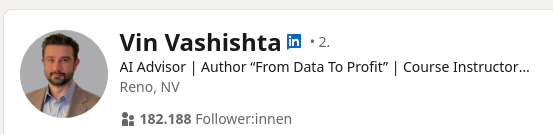
- Is there an easier way to to this?
- How much does it cost to run the application
- What is the benefit?

### Don't get fired as an AI Engineer
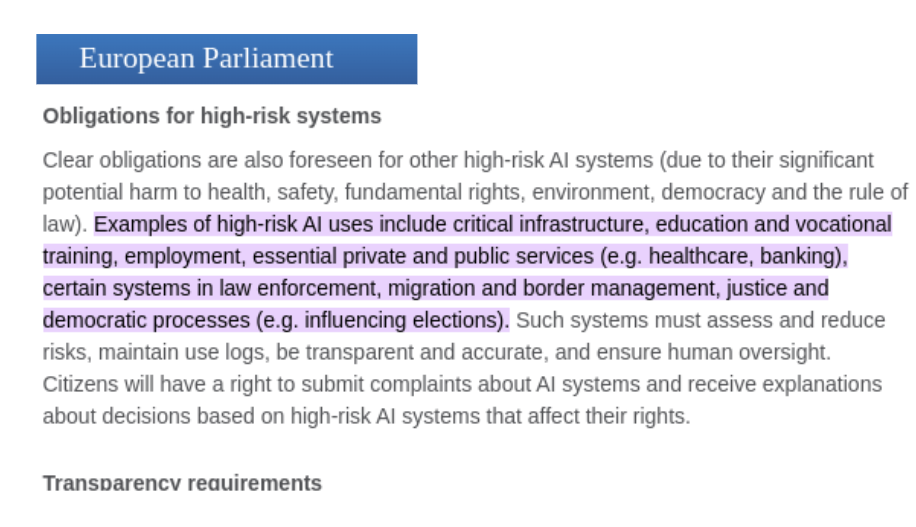


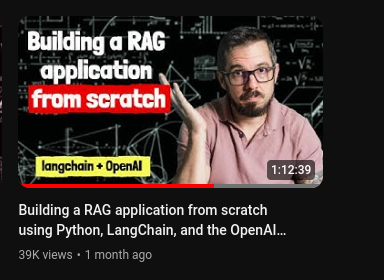

